# Floresta Aleatória
**Variáveis Agregadas (2010-2017)** \\
 \\
Bootcamp Machine Learning ENAP 2024 \\
Maurício Marques Soares Filho \\
25/10/2024 \\

In [2]:
###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dtreeviz

###
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.inspection import permutation_importance

###
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

###
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

###
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier


###
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV

###
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Pré-processamento dos dados

In [3]:
#Estilizar conteúdo
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

def estilo_tabelas(df, max_altura='300px', casas_decimais=3):
    return (
        df.style.set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '100px')]},
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},  # Bordas cinza escuro
            ]
        ).set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        ).set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'
        ).format(
            precision=casas_decimais
        )
    )

In [4]:
# Importar a base de dados
df_eventos_2010_2017_modelo1 = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2010_2017_modelo1.csv",
    sep=';',
    decimal=',',
)

estilo_tabelas(df_eventos_2010_2017_modelo1.head(5))

,Status,DH_total_danos_humanos,DM_total_danos_materiais,PEPL_total_publico,PEPR_total_privado,regiao_Centro-oeste,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,COBRADE_11110,COBRADE_11120,COBRADE_11311,COBRADE_11312,COBRADE_11313,COBRADE_11321,COBRADE_11331,COBRADE_11332,COBRADE_11340,COBRADE_11410,COBRADE_11420,COBRADE_11431,COBRADE_11432,COBRADE_11433,COBRADE_12100,COBRADE_12200,COBRADE_12300,COBRADE_13111,COBRADE_13112,COBRADE_13120,COBRADE_13211,COBRADE_13212,COBRADE_13213,COBRADE_13214,COBRADE_13215,COBRADE_13310,COBRADE_13321,COBRADE_13322,COBRADE_14110,COBRADE_14120,COBRADE_14131,COBRADE_14132,COBRADE_14140,COBRADE_15110,COBRADE_15120,COBRADE_15130,COBRADE_15210,COBRADE_15230,COBRADE_22210,COBRADE_22220,COBRADE_23120,COBRADE_24100,COBRADE_24200,COBRADE_25100,COBRADE_25500,Rendapercapita
0,1,4000,166542.286,6120428.994,7286224.972,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,17.934
1,1,8034,0.000,0.000,7639477.192,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.605
2,1,2732,0.000,0.000,26406.490,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,13.655
3,1,0,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.997
4,1,0,2048392.375,2617.833,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10.594


In [5]:
# Remover linhas com dados ausentes
df_eventos_2010_2017_modelo1 = df_eventos_2010_2017_modelo1.dropna()
estilo_tabelas(df_eventos_2010_2017_modelo1.head(5))

# Remover registros em que todos os dados informados são nulos
df_eventos_2010_2017_modelo1 = df_eventos_2010_2017_modelo1[
    ~((df_eventos_2010_2017_modelo1['DH_total_danos_humanos'] == 0) &
      (df_eventos_2010_2017_modelo1['DM_total_danos_materiais'] == 0) &
      (df_eventos_2010_2017_modelo1['PEPL_total_publico'] == 0) &
      (df_eventos_2010_2017_modelo1['PEPR_total_privado'] == 0))
]

In [6]:
# Dimensões do dataset
status_counts = df_eventos_2010_2017_modelo1['Status'].value_counts()
print("\nContagem da variável 'Status':")
status_counts.index=['Reconhecido', 'Não Reconhecido']
display(status_counts)


Contagem da variável 'Status':


,count
Reconhecido,9156
Não Reconhecido,1095


## Modelo Sem Balanceamento

In [7]:
# Divisão em Dados de Treino e Teste
df_eventos_2010_2017_modelo1 = df_eventos_2010_2017_modelo1.sample(frac=1, random_state=42).reset_index(drop=True, inplace=False)
X_2010_2017_modelo1 = df_eventos_2010_2017_modelo1.drop('Status', axis=1)
y_2010_2017_modelo1 = df_eventos_2010_2017_modelo1['Status']
X_train_2010_2017_modelo1, X_test_2010_2017_modelo1, y_train_2010_2017_modelo1, y_test_2010_2017_modelo1 = train_test_split(X_2010_2017_modelo1, y_2010_2017_modelo1, test_size = 0.2, random_state = 42, stratify = y_2010_2017_modelo1)

# Dimensões do dataset de treino
status_counts = y_train_2010_2017_modelo1.value_counts()
print("\nDimensões do dataset de treino:")
status_counts.index=['Reconhecido', 'Não Reconhecido']
display(status_counts)

# Dimensões do dataset de teste
status_counts = y_test_2010_2017_modelo1.value_counts()
print("\nDimensões do dataset de teste:")
status_counts.index=['Reconhecido', 'Não Reconhecido']
display(status_counts)


Dimensões do dataset de treino:


,count
Reconhecido,7324
Não Reconhecido,876



Dimensões do dataset de teste:


,count
Reconhecido,1832
Não Reconhecido,219


In [8]:
# Treinamento

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'rf_class_0__criterion': ['gini', 'entropy'],
    'rf_class_0__n_estimators': [150, 175, 200, 225, 250, 300],
    'rf_class_0__max_depth': [2, 4, 6, 8],
    'rf_class_0__min_samples_split': [2, 5, 10, 15, 100],
    'rf_class_0__min_samples_leaf': [1, 2, 5, 10],
    'rf_class_0__max_features': ['sqrt', 'log2', None]
}

# Criar pipeline com RobustScaler e RandomForestClassifier
pipeline_rf_class_0 = Pipeline([
    ('scaler', RobustScaler()),
    ('rf_class_0', RandomForestClassifier(random_state = 42))
])

# Realizar a busca bayesiana com validação cruzada
bayes_search_rf_class_0 = BayesSearchCV(
    pipeline_rf_class_0,
    search_spaces = param_grid_bayes,
    n_iter = 30,
    cv = 5,
    scoring = 'f1_weighted',
    n_jobs = 1,
    random_state = 42
)

# Ajustar a busca bayesiana ao conjunto de treino
bayes_search_rf_class_0.fit(X_train_2010_2017_modelo1, y_train_2010_2017_modelo1)

# Melhor modelo encontrado
best_rf_class_0_model = bayes_search_rf_class_0.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {bayes_search_rf_class_0.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_rf_class_0 = best_rf_class_0_model.predict(X_test_2010_2017_modelo1)

# Relatório de classificação
classification_report_rf_class_0 = metrics.classification_report(y_test_2010_2017_modelo1, y_pred_rf_class_0, digits=6, target_names=['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest: \n')
print(classification_report_rf_class_0)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast


Melhores hiperparâmetros: OrderedDict([('rf_class_0__criterion', 'gini'), ('rf_class_0__max_depth', 8), ('rf_class_0__max_features', None), ('rf_class_0__min_samples_leaf', 2), ('rf_class_0__min_samples_split', 2), ('rf_class_0__n_estimators', 150)])

 Classification report para Random Forest: 

                 precision    recall  f1-score   support

Não reconhecido   0.800000  0.054795  0.102564       219
    Reconhecido   0.898330  0.998362  0.945708      1832

       accuracy                       0.897611      2051
      macro avg   0.849165  0.526578  0.524136      2051
   weighted avg   0.887831  0.897611  0.855680      2051



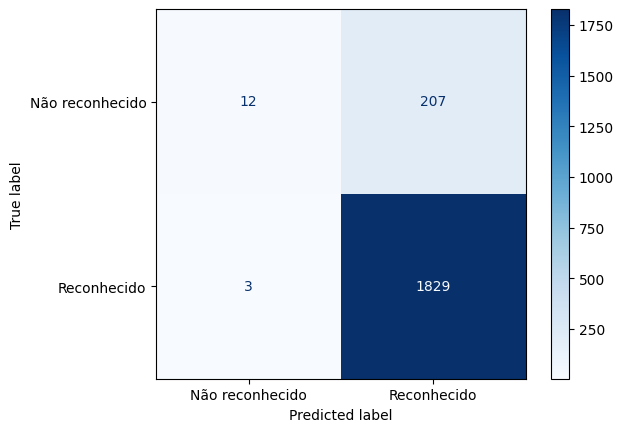

In [9]:
# Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(best_rf_class_0_model, X_test_2010_2017_modelo1, y_test_2010_2017_modelo1, values_format='d', cmap='Blues', display_labels=['Não reconhecido', 'Reconhecido'])

## Balanceamento de Dados com SMOTE

In [10]:
# Divisão em Dados de Treino e Teste
X_smote = df_eventos_2010_2017_modelo1.drop('Status', axis=1)
y_smote = df_eventos_2010_2017_modelo1['Status']
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 42, stratify = y_smote)

In [11]:
# Aplicar SMOTE apenas no conjunto de treino
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_smote, y_train_smote)

In [12]:
# Treinamento

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'rf_class_1__criterion': ['gini', 'entropy'],
    'rf_class_1__n_estimators': [150, 175, 200, 225, 250, 300],
    'rf_class_1__max_depth': [2, 4, 6, 8],
    'rf_class_1__min_samples_split': [2, 5, 10, 15, 100],
    'rf_class_1__min_samples_leaf': [1, 2, 5, 10],
    'rf_class_1__max_features': ['sqrt', 'log2', None]
}

# Criar pipeline com RobustScaler e RandomForestClassifier
pipeline_rf_class_1 = Pipeline([
    ('scaler', RobustScaler()),
    ('rf_class_1', RandomForestClassifier(random_state = 42))
])

# Realizar a busca bayesiana com validação cruzada
bayes_search_rf_class_1 = BayesSearchCV(
    pipeline_rf_class_1,
    search_spaces = param_grid_bayes,
    n_iter = 30,
    cv = 5,
    scoring = 'f1_weighted',
    n_jobs = 1,
    random_state = 42
)

# Ajustar a busca bayesiana ao conjunto de treino
bayes_search_rf_class_1.fit(X_train_smote, y_train_smote)

# Melhor modelo encontrado
best_rf_class_1_model = bayes_search_rf_class_1.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {bayes_search_rf_class_1.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_rf_class_1 = best_rf_class_1_model.predict(X_test_smote)

# Relatório de classificação
classification_report_rf_class_1 = metrics.classification_report(y_test_smote, y_pred_rf_class_1, digits=6, target_names=['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest com SMOTE: \n')
print(classification_report_rf_class_1)

Melhores hiperparâmetros: OrderedDict([('rf_class_1__criterion', 'gini'), ('rf_class_1__max_depth', 8), ('rf_class_1__max_features', 'sqrt'), ('rf_class_1__min_samples_leaf', 1), ('rf_class_1__min_samples_split', 5), ('rf_class_1__n_estimators', 225)])

 Classification report para Random Forest com SMOTE: 

                 precision    recall  f1-score   support

Não reconhecido   0.389937  0.283105  0.328042       219
    Reconhecido   0.917019  0.947052  0.931794      1832

       accuracy                       0.876158      2051
      macro avg   0.653478  0.615079  0.629918      2051
   weighted avg   0.860739  0.876158  0.867327      2051



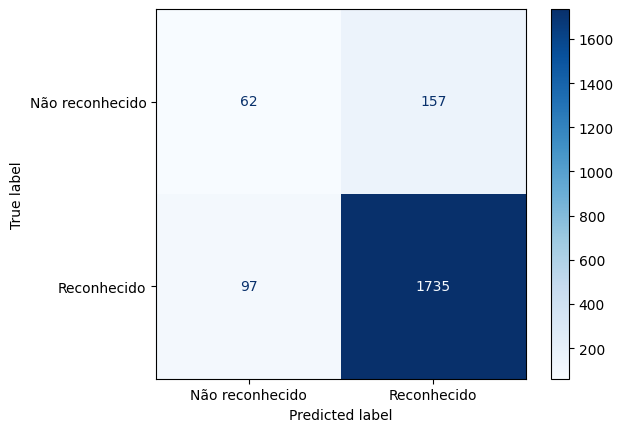

In [13]:
# Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(best_rf_class_1_model, X_test_smote, y_test_smote, values_format='d', cmap='Blues', display_labels=['Não reconhecido', 'Reconhecido'])

## Avaliação das Variáveis de Importância
Avaliação das variáveis de importância de acordo com o modelo desbalanceado,  que apresentou o maior f1-score.

In [15]:
# Passo intermediário
X_train     = X_train_2010_2017_modelo1
y_train     = y_train_2010_2017_modelo1
X_test      = X_test_2010_2017_modelo1
y_test      = y_test_2010_2017_modelo1
model_type  = 'rf_class_0'
best_model  = best_rf_class_0_model

# Ajustar o melhor modelo encontrado (depois da busca bayesiana)
best_model.named_steps[model_type].fit(X_train, y_train)

# Obter a importância das features
importance_dict = {}
for feature, importance in zip(X_train.columns, best_model.named_steps[model_type].feature_importances_):
    importance_dict[feature] = importance
#importance_dict

# Transformar em DataFrame para organizar como tabela
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
})

# Ordenar pela importância em ordem decrescente
importance_df = importance_df.sort_values(by='Importance', ascending=False)
estilo_tabelas(importance_df.head(10))

,Feature,Importance
54,Rendapercapita,0.194
0,DH_total_danos_humanos,0.170
3,PEPR_total_privado,0.160
2,PEPL_total_publico,0.104
1,DM_total_danos_materiais,0.094
8,regiao_Sul,0.042
40,COBRADE_14132,0.034
5,regiao_Nordeste,0.030
32,COBRADE_13214,0.029
6,regiao_Norte,0.025


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names


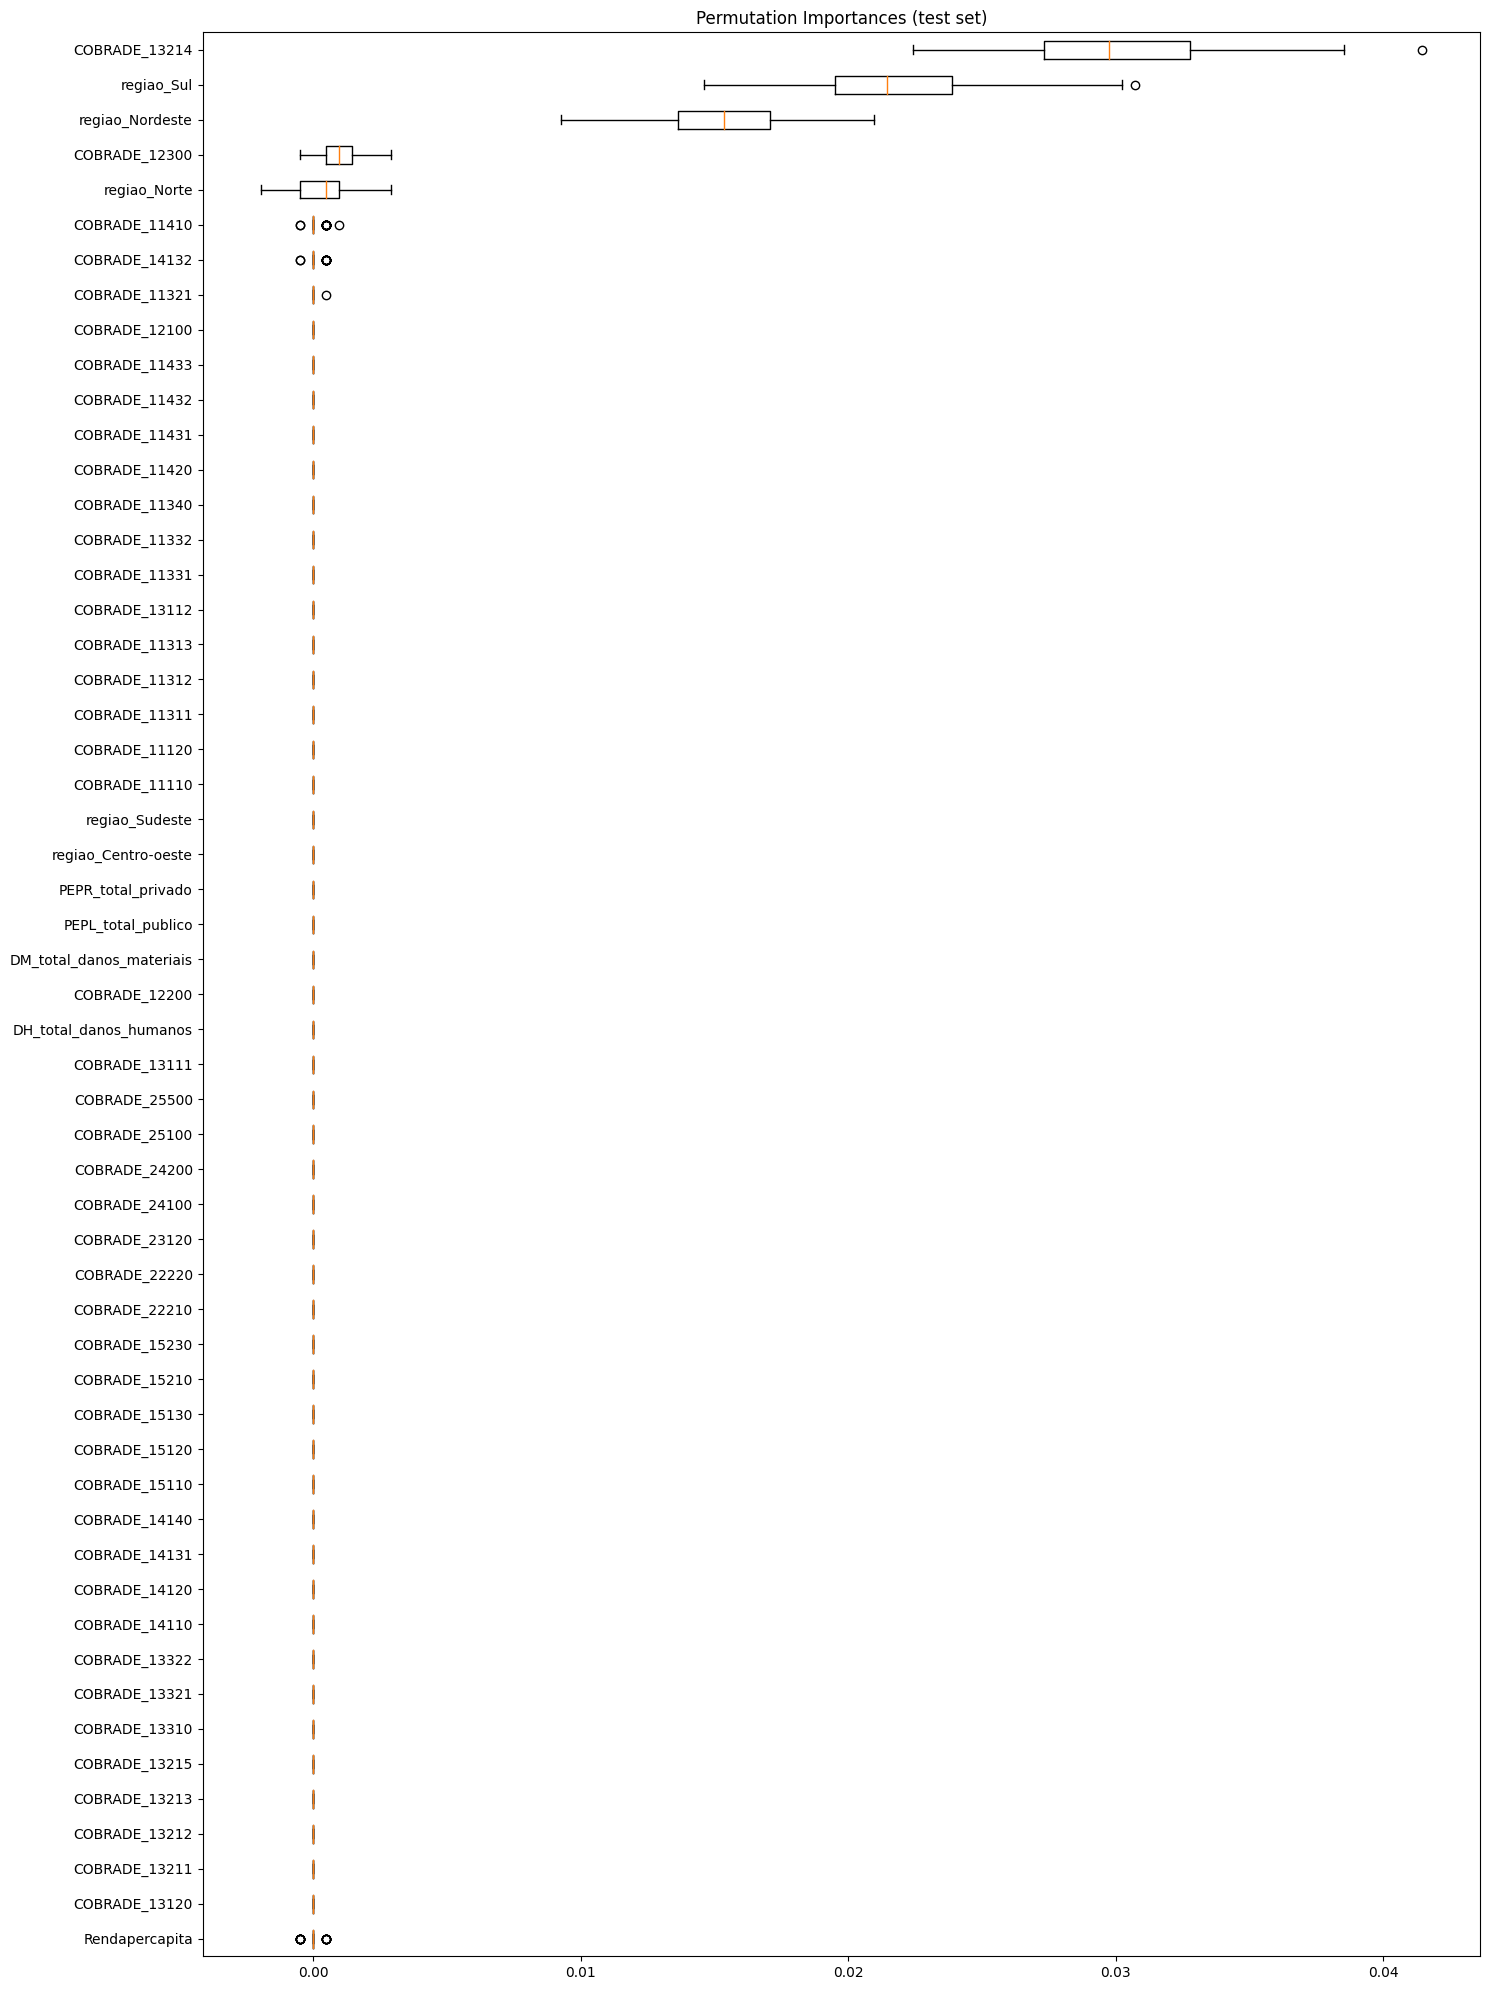

In [16]:
# Calcular os resultados (permutation_importance) da queda no desempenho do modelo ao embaralhar cada uma das variáveis.
result = permutation_importance(best_model, X_test, y_test, n_repeats=100, random_state = 42, n_jobs = -1)

# Ordenar os resultados
sorted_idx = result.importances_mean.argsort()

# Gráfico boxplot pra mostrar a importância das variáveis
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.set_size_inches(15, 20)
fig.tight_layout()
plt.show()